# The Lukewarm Hand, part 2

I decided to code up a simulation of what a "lukewarm" player might look like. How would that affect the distribution of z scores?

I'm not totally sure how to model it, because the whole idea is kind of ridiculous.

In [1]:
import streaky_players
import wald_wolfowitz
import streak_converter

# the song of my people
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats

## Gotta Start Somewhere

First, a really naive attempt. Each player will put up 900 shots a year, split across 60 games. I'm making the base shooting percentage 50%. If a player, call him Luke, has taken at least 8 attempts in the game, and made at least 80% of them, his shooting percentage goes down to 30%, and if he's missed at least 80% of them, his shooting percentage goes up to 70%.

In [ ]:
def sim_season():
    GAMES = 60 # they miss some games, say
    SHOTS = 15 # this is actually pretty high for an average player, I think

    luke = streaky_players.LukewarmPlayer(shooting_percentage=.5)
    luke.MIN_ATTEMPTS = 8

    makes_misses = []
    for game in range(GAMES):
        for shot in range(SHOTS):
            makes_misses.append(luke.take_shot())
        luke.end_game()
    return pd.Series(makes_misses)

def handle_season(results):
    makes = sum(results > 0)
    misses = sum(results == 0)
    if (makes + misses) > 3:
        expected = wald_wolfowitz.get_expected_streaks(makes, misses)
        streak_data = streak_converter.convert_to_streaks(results)
        total_streaks = streak_data['total_streaks']
        variance = wald_wolfowitz.get_variance(makes, misses, expected)
        if variance > 0:
            z_score = (total_streaks - expected) / np.sqrt(variance)
            return (total_streaks, expected, variance, z_score)
        else:
            return None
    else:
        return None # not enough data!

def sim_multiple(num_seasons):
    seasons_result = []
    for x in range(num_seasons):
        results = sim_season()
        stat_results = handle_season(results)
        seasons_result.append(stat_results)

    return seasons_result

I'm going to look at 5000 simulated players.

In [298]:
luke = sim_multiple(1000) # FIXME: speed

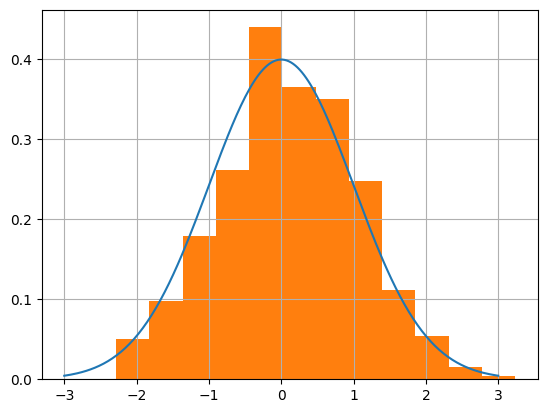

In [299]:
def summary_plot(sim):
    sim_summary = pd.DataFrame(sim, columns=["actual", "expected", "variance", "z_score"])
    x = np.linspace(-3,3,200)
    plt.plot(x, scipy.stats.norm.pdf(x, 0, 1))
    sim_summary.z_score.hist(bins=12, density=True)

    return sim_summary


luke_summary = summary_plot(luke)

In [300]:
luke_summary.z_score.describe()

count    1000.000000
mean        0.108639
std         0.947378
min        -2.285199
25%        -0.514253
50%         0.076215
75%         0.767948
max         3.233968
Name: z_score, dtype: float64

as expected it did shift the mean to the right ("unstreaky" side), but didn't increase the standard deviation.

I should simulate a realistic season with the shooting percentages and number of attempts matching actual players.

In [6]:
import player_streaks
ps = player_streaks.PlayerStreaks()

actual_data = ps.get_data_with_stats()

In [7]:
df_season = pd.DataFrame({'attempts': actual_data.makes + actual_data.misses,
                          'shooting_percentage': actual_data.makes / (actual_data.makes + actual_data.misses)})

In [8]:
df_season

,attempts,shooting_percentage
player_id,,
1630173,327,0.501529
203500,167,0.544910
1628389,1113,0.485175
1630534,534,0.498127
1630583,648,0.483025
...,...,...
1629027,1376,0.411337
1627826,942,0.628450
1641783,483,0.412008


I will loop through df_season and simulate each one with lukewarmplayer. the problem is I don't have a realistic number of shots per game, because I didn't collect number of games played.

I found 4 attempts before the "unstreaky" behavior kicks in to produce pretty realistic results.

In [ ]:
def sim_season_realistic(df):
    results = []
    for i, row in df.iterrows():
        sim_player = streaky_players.LukewarmPlayer(shooting_percentage=row.shooting_percentage)
        sim_player.MIN_ATTEMPTS = 4 # when streakiness kicks in. I don't know what number this should be.

        ### THIS IS A WILD ASS GUESS, I have no idea how shot attampts per game are distributed
        ### and should be using actual number of shots for each game.
        approx_games = 50
        approx_attempts = int(np.ceil(row.attempts/approx_games))
        makes_misses = []
        # like in the original research, I am concatenating game results
        # onto one long season-wide list
        for game in range(approx_games):
            for shot in range(approx_attempts):
                makes_misses.append(sim_player.take_shot())
            sim_player.end_game()
        season_stats = handle_season(pd.Series(makes_misses))
        if season_stats:
            results.append(season_stats)
    return results            

In [10]:
ssr = sim_season_realistic(df_season)

In [11]:
sim_summary = pd.DataFrame(ssr, columns=["actual", "expected", "variance", "z_score"])
    

In [12]:
sim_summary.z_score.describe()

count    554.000000
mean       0.246411
std        1.021603
min       -3.900238
25%       -0.385633
50%        0.259841
75%        0.895395
max        3.301452
Name: z_score, dtype: float64

For reference, here were the actual numbers from the 2024-5 season:


```
count    554.000000
mean       0.212491
std        1.075563
min       -3.081194
25%       -0.546340
50%        0.236554
75%        0.951653
max        3.054836
Name: z_score, dtype: float64

```

I don't think my model is really capturing the overdispersion. messing around with this simple sort of model hasn't 

ideas:


high volume shooters are extra unstreaky? (this is implicitly happening because the anti-streakiness doesn't kick in until 4+ shots)

unstreakiness works only in one direction? (don't get a boost when missing a lot, do get a penalty when making a lot)?

I want actual # of shots per each game (not just average). make sim as close as possible. sometimes role players will have 1 or 2 games where they shoot a bunch of shots

model a mixture of extra unstreaky and regular players?

In [14]:
actual_data

,player_name,makes,misses,total_streaks,raw_data,expected_streaks,variance,sd,z_score
player_id,,,,,,,,,
1630173,Precious Achiuwa,164,163,157,WLLLWWLWWLLWLLWLLLWWWWWLLLWLLWWLLLWLLLWWWLWLWW...,164.498471,81.497704,9.027608,-0.830615
203500,Steven Adams,91,76,87,LWWWLLWLWWWLWLLLWWWLWWWWWLLWWWWLWLLWWWLWLWLWWW...,83.826347,40.827575,6.389646,0.496687
1628389,Bam Adebayo,540,573,569,LLWLWWWLWLWWWLLWLLWLWWWLWLWWWWLWWWLLWWWLWLLWWL...,557.010782,277.510772,16.658655,0.719699
1630534,Ochai Agbaji,266,268,277,WLLLLWLWLWWLWLLLLWLLLLLWLLLWWWWWLWWWLWWWWWLLWL...,267.996255,133.245786,11.543214,0.780003
1630583,Santi Aldama,313,335,327,LWLLLLWLWWWWWLWWWLWWLWLWLLLWWWWWWLWWWLWWWWWWLL...,324.626543,161.376372,12.703400,0.186836
...,...,...,...,...,...,...,...,...,...
1629027,Trae Young,566,810,678,LLWLLLLWLWLLLLWLWLLWLWWLLWLLLWWWLLWLWWWLWLWLWW...,667.366279,322.456474,17.957073,0.592175
1627826,Ivica Zubac,592,350,445,WLWLLLLWLWWWLWLWWWWWLWWWWWLLWLLWLLLWWWWLWWWWLL...,440.915074,205.191666,14.324513,0.285170
1641783,Tristan da Silva,199,284,245,LWLWLLLLWLWWLWLWWLWLWLLWWLWWWWLWLWWLLLLWLWWLLW...,235.020704,113.136243,10.636552,0.938208


## Improving the Simulation
I'm not happy with the fact that I'm not following the actual number of shots per game.

I need complete shot data. If ound it downloadable from kaggle:

https://www.kaggle.com/datasets/mexwell/nba-shots

this is only up to 2023-24. the files are named after the 2nd year (2024) of the season rather than the first

In [ ]:
shots =  pd.read_csv("kaggle_data/NBA_2024_Shots.csv")

In [122]:
shots.head()

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,...,BASIC_ZONE,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT
0,2024,2023-24,1610612764,Washington Wizards,1629673,Jordan Poole,G,SG,11-03-2023,22300003,...,In The Paint (Non-RA),Center,C,8-16 ft.,-0.4,17.45,12,1,11,1
1,2024,2023-24,1610612764,Washington Wizards,1630166,Deni Avdija,F,SF,11-03-2023,22300003,...,Above the Break 3,Center,C,24+ ft.,1.5,30.55,25,1,10,26
2,2024,2023-24,1610612764,Washington Wizards,1626145,Tyus Jones,G,PG,11-03-2023,22300003,...,Restricted Area,Center,C,Less Than 8 ft.,-3.3,6.55,3,1,9,46
3,2024,2023-24,1610612764,Washington Wizards,1629673,Jordan Poole,G,SG,11-03-2023,22300003,...,Restricted Area,Center,C,Less Than 8 ft.,-1.0,5.85,1,1,8,30
4,2024,2023-24,1610612764,Washington Wizards,1626145,Tyus Jones,G,PG,11-03-2023,22300003,...,Restricted Area,Center,C,Less Than 8 ft.,-0.0,6.25,1,1,8,8


In [ ]:

combined_df = pd.DataFrame(columns=["player_id", "game_id", "makes", 
                                "misses", "total_streaks", "raw_data"])
combined_df = combined_df.set_index(["player_id", "game_id"])


for key, results in shots.groupby(["PLAYER_ID", "GAME_ID"])["SHOT_MADE"]:
    streak_data = "".join(results.replace(True, "W").replace(False, "L"))
    as_streaks = streak_converter.convert_to_streaks(False, streak_data)

    combined_df.loc[key, :] = [as_streaks['makes'], as_streaks['misses'],
                                  as_streaks['total_streaks'], as_streaks['raw_data']
                                ]

In [ ]:
#combined_df.to_pickle("caseytestingstuff.pkl")

In [76]:
combined_df['expected_streaks'] = wald_wolfowitz.get_expected_streaks(combined_df.makes, combined_df.misses)

In [77]:
combined_df

makes misses total_streaks                raw_data  \
player_id game_id                                                       
2544      22300015    11      6             9       LWLWLWWWWWWWLLWWL   
          22300026     6      5             5             WWLWLLLLWWW   
          22300036    13      9            16  WLWWLWLWWWLWWLWLWWLLWL   
          22300042     6      4             7              WLWLLWWWLW   
          22300061    10      6            11        WLWLLWWLWWLWWWLW   
...                  ...    ...           ...                     ...   
1642013   22301108     0      7             1                 LLLLLLL   
          22301146     3      5             4                WLLWWLLL   
          22301160     3      7             5              LLLWWLLWLL   
          22301176     0      2             1                      LL   
          22301189     3      4             5                 WLWLLLW   

                   expected_streaks  
player_id game_id                    
2544      22300015         8.764706  
          22300026         6.454545  
          22300036        11.636364  
          22300042              5.8  
          22300061              8.5  
...                             ...  
1642013   22301108              1.0  
          22301146             4.75  
          22301160              5.2  
          22301176              1.0  
          22301189         4.428571  

[24895 rows x 5 columns]

here's evidence of un-streaky behavior at the game-by-game level. there are a lot more player-game combos with too many streaks than too few streaks.

In [78]:
streak_diff = combined_df.total_streaks - combined_df.expected_streaks

In [81]:
sum(streak_diff > 0)

10285

In [82]:
sum(streak_diff < 0)

8977

In [178]:
sum(streak_diff == 0)

5633

we'd expect there to be as many streaks with negative z scores as positive ones. The imbalance is significant.

In [150]:
scipy.stats.chisquare([10285, 8977])


Power_divergenceResult(statistic=np.float64(88.8206832104662), pvalue=np.float64(4.322725746451667e-21))

## Game-level z scores

have to redo some previous ETL here with the new data.

In [ ]:
# have to drop ones where variance is undefined

clean_df = combined_df[(combined_df.variance > 0) & (combined_df.makes + combined_df.misses) > 3].copy()

In [99]:
clean_df['variance'] = wald_wolfowitz.get_variance(clean_df.makes, 
                                                      clean_df.misses, 
                                                      clean_df.expected_streaks)

In [100]:
clean_df.head()

makes misses total_streaks                raw_data  \
player_id game_id                                                       
2544      22300015    11      6             9       LWLWLWWWWWWWLLWWL   
          22300026     6      5             5             WWLWLLLLWWW   
          22300036    13      9            16  WLWWLWLWWWLWWLWLWWLLWL   
          22300042     6      4             7              WLWLLWWWLW   
          22300061    10      6            11        WLWLLWWLWWLWWWLW   

                   expected_streaks  variance  
player_id game_id                              
2544      22300015         8.764706  3.282872  
          22300026         6.454545  2.429752  
          22300036        11.636364  4.880756  
          22300042              5.8  2.026667  
          22300061              8.5      3.25

Because these are small sample sizes, and we're comparing an integer value (actual number of runs) with a value from a continuous probability distribution (theoretical number of runs) one *could* do a continuity correction here.


The way the [SAS version of the test](https://support.sas.com/kb/33/092.html) does it, when sample size is less than 50, when calculating z-score: 

* if actual - theoretical < 0, adds .5 to numerator
* if actual - theoretical > 0, subtracts .5 from numerator

This doesn't make any sense to me. For a hypothesis test, the correct thing to do would be use a lookup table where someone has calculated the exact probabilities.  https://webspace.ship.edu/pgmarr/Geo441/Tables/Runs%20Table.pdf 

The real problem is the normal approximation doesn't fit the actual distribution in small samples. the continuity correction doesn't fix that.

For the sake of thoroughness, I worked it out below. I don't think it's appropriate for my purposes. I'm not doing a hypothesis test on one individual player's record in one game, I'm looking at the distribution of 20,000 of them and using the Z score as a measurement of "relative weirdness".

In [209]:
clean_df.loc[clean_df.total_streaks < clean_df.expected_streaks, 'z_score_cc'] = (clean_df.total_streaks - clean_df.expected_streaks + .5) / ((clean_df.variance)**.5)
clean_df.loc[clean_df.total_streaks >= clean_df.expected_streaks, 'z_score_cc'] = (clean_df.total_streaks - clean_df.expected_streaks - .5) / ((clean_df.variance)**.5)


In [107]:
clean_df['z_score'] = (clean_df.total_streaks - clean_df.expected_streaks) / ((clean_df.variance)**.5)

In [ ]:

def plot_z(z_plot):
    x = np.linspace(-3,3,200)
    plt.plot(x, scipy.stats.norm.pdf(x, 0, 1))

    out = plt.hist(z_plot, bins=np.arange(-3,3,.5), density=True)
    plt.title("individual game z-scores, 2023-24 season")

this is the distribution with continuity correction, which is clearly ridiculous

In [215]:
clean_df.z_score_cc.astype("float").describe()

count    18982.000000
mean        -0.031954
std          0.687916
min         -3.047828
25%         -0.401101
50%          0.000000
75%          0.302765
max          3.390395
Name: z_score_cc, dtype: float64

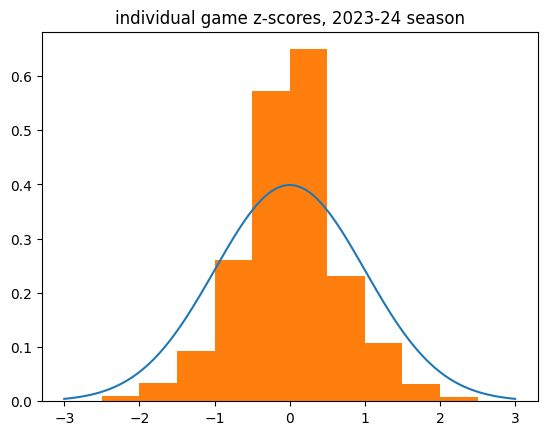

In [216]:
plot_z(clean_df.z_score_cc)

### On fairness
I could instead calculate number of streaks expected for a player who shoots x% from the field...

say a player who is usually a 50% shooter takes 8 shots in a game and makes all 8.

the player didn't miss any shots, so we'd expect only 1 streak.

however, if they went 4 for 8 like a usual night, we'd expect `4 + 1 = 5` streaks.

using the same # of makes/misses as the real game is a stricter way to define it (and fairer, if you don't buy the *Lukewarm Hand*)

It's throwing out intra-game streakiness in a way. It's modeling the idea that one day, a shooter really is a 60% shooter and the next day they really are a 20% shooter, rather than being a 40% shooter both days.

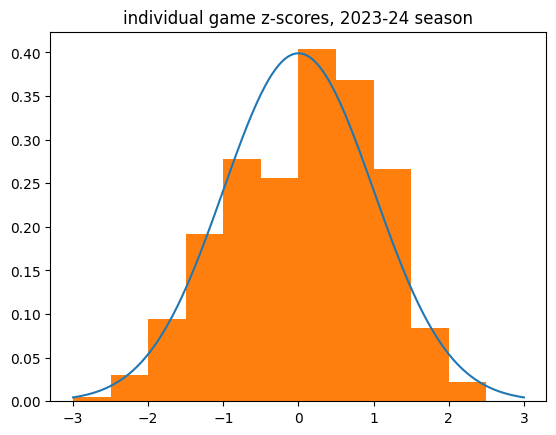

In [183]:
z_plot = clean_df.z_score.astype("float")

plot_z(z_plot)

In [181]:
z_plot.describe()

count    18982.000000
mean         0.051765
std          0.988789
min         -3.332292
25%         -0.707107
50%          0.104103
75%          0.816497
max          3.583243
Name: z_score, dtype: float64

game level z scores are normally distributed.

In [182]:
scipy.stats.shapiro(z_plot.sample(1000))

ShapiroResult(statistic=np.float64(0.9868901535685428), pvalue=np.float64(8.418812690107912e-08))

although the mean is small, the sample size is large, so it is significant

In [308]:
.051765 / np.sqrt(1/18982)

np.float64(7.131932150613184)

### Big Games Only

I think there are probably a lot of games where number of expected streaks is only 1 or 2. what about higher number expected?

In [145]:
sum(clean_df.expected_streaks < 10)

17142

In [146]:
sum(clean_df.expected_streaks >= 10)

1840

In [138]:
big_games = clean_df[(clean_df.makes > 10) | (clean_df.misses > 10)].z_score.astype("float")

There are around 2500 player-games where there were at least 10 makes or misses by the player.

In [185]:
big_games.describe()

count    2536.000000
mean        0.055925
std         1.010195
min        -3.079575
25%        -0.616678
50%         0.072404
75%         0.750366
max         3.583243
Name: z_score, dtype: float64

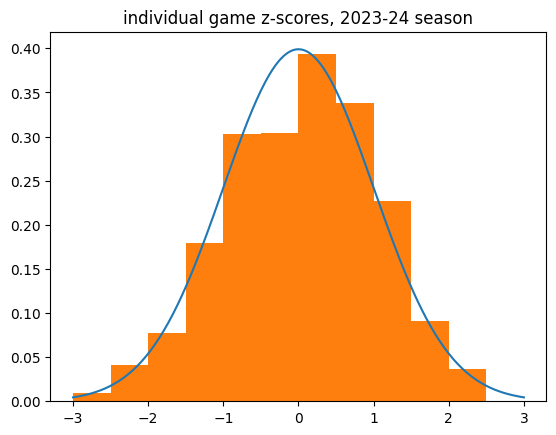

In [184]:
plot_z(big_games)

In [164]:
sum(big_games > 0)

1333

In [165]:
sum(big_games < 0)

1154

the imbalance is still there in the big games.

In [166]:
scipy.stats.chisquare([1333, 1154])

Power_divergenceResult(statistic=np.float64(12.883393646964214), pvalue=np.float64(0.00033151055973599483))

### Is the Wald-Wolfowitz test "fair"?

Yeah, it is. As discussed before, the distribution of the number of streaks is only approximately normal when it's a small sample size (a player's single game result). But the estimate of the mean is exact.

Say we've got 7 makes and 4 misses. The W-W test says there will be 6.0909... streaks. It's not a whole number because it's not returning the *most likely* number of streaks (which would be 6), it's returning the *exact* mean number of streaks.

In [304]:
expected_streaks = wald_wolfowitz.get_expected_streaks(7,4)

expected_streaks

6.090909090909091

We can calculate the *exact* probabilities of each number of streaks, conditioned on the fact that there are 7 wins and 4 losses.

In [277]:
# loop through all possible combinations of 7 wins, 4 losses
# calculate the number of streaks for EVERY combination

# unlike the normal approx of the wald-wolfowitz test, this will give the EXACT probabilities
# of each streak length (assuming the order of the makes/misses are independent)

import itertools
import math

# I don't know why itertools doesn't have a "distinct permutations" function!
perms = set()
for x in itertools.permutations([0,0,0,0,1,1,1,1,1,1,1], 11):
    perms.add(x)

expected_perms = math.factorial(11)  / (math.factorial(7) * math.factorial(4))
assert len(perms) == expected_perms, "casey forgot how to do math!"

exact_df = pd.DataFrame(columns=["zeroes", "ones", "streaks", "as_str"])
for x in list(perms):
    perm = pd.Series(x)
    streak_data = streak_converter.convert_to_streaks(perm)
    exact_df.loc[len(exact_df)]  = [streak_data['misses'], streak_data['makes'], 
                        streak_data['total_streaks'], "".join(perm.replace(0, "0").replace(1, "1"))]

In [278]:
exact_df

,zeroes,ones,streaks,as_str
0,4,7,6,11001110110
1,4,7,7,10100110111
2,4,7,4,00100111111
3,4,7,5,01111001110
4,4,7,6,01110010111
...,...,...,...,...
325,4,7,5,11110001101
326,4,7,7,01101110110
327,4,7,3,00111111100
328,4,7,9,11101010101


In [260]:
exact_df.streaks.describe()

count    330.000000
mean       6.090909
std        1.445329
min        2.000000
25%        5.000000
50%        6.000000
75%        7.000000
max        9.000000
Name: streaks, dtype: float64

The actual standard deviation (above) is very very close to the theoretical value.

In [305]:
np.sqrt(wald_wolfowitz.get_variance(7,4,expected_streaks))

np.float64(1.443137078762504)

It doesn't look normal. it's definitely not symmetric. it looks more like a binomial distribution.

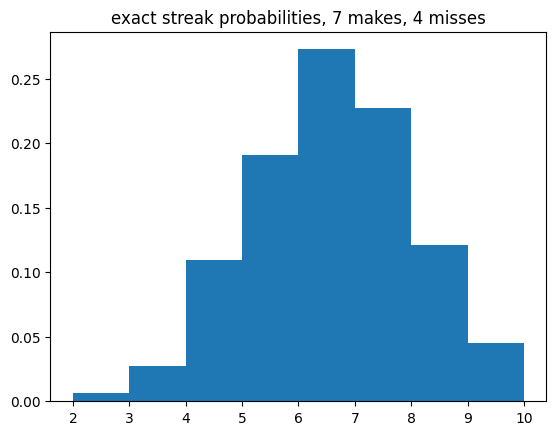

In [270]:
exact_hist = plt.hist(exact_df.streaks, density=True, bins=[2,3,4,5,6,7,8,9,10])
_trash = plt.title("exact streak probabilities, 7 makes, 4 misses")

Individual games are very small sample sizes. But we should see a very similar distribution as the above if we look at actual player games with 7 makes and 4 misses.

And we do!

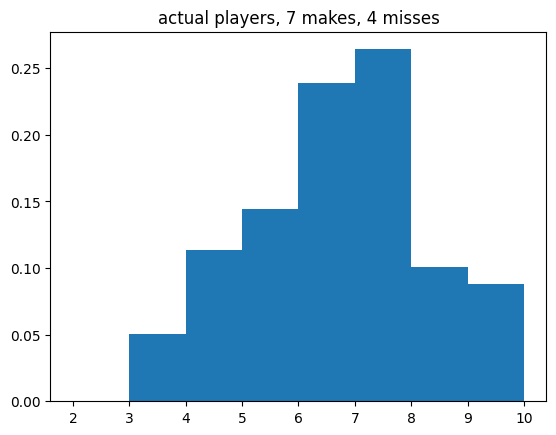

In [297]:
actual_streaks = clean_df[(clean_df.makes == 7) & (clean_df.misses ==4)].total_streaks.astype("float")

actual_hist = plt.hist(actual_streaks, bins=range(2,11), density=True)

_trash = plt.title("actual players, 7 makes, 4 misses")

here are the two histograms on top of each other. Orange is where there were more actual streaks, blue where there were more theoretical streaks, and brown is where they overlap.

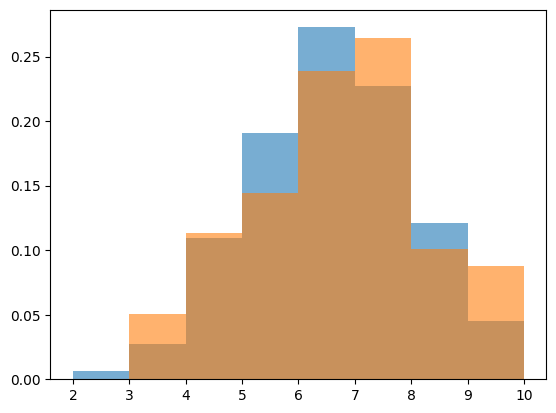

In [296]:
_trash = plt.hist(exact_df.streaks, density=True, bins=range(2,11), alpha=0.6)
_trash = plt.hist(actual_streaks, bins=range(2,11), density=True, alpha=0.6)

## Back to simulation

OK, now that I have actual shot data, I can make the lukewarm player simulation more realistic. Unlike the tests above, I'm not going to match the player's exact number of makes and misses. (I can't.) I will have "Luke", our lukewarm simulation, take the exact number of shots in each player-game, at the player's season-wide shooting percentage.

In [ ]:
FIXME: 

In [ ]:
# get season-wide field goal percentage for each player ID
makes = combined_df.groupby("player_id")["makes"].sum()
misses = combined_df.groupby("player_id")["misses"].sum()

fg_percentage = makes / (makes + misses)

In [315]:
fg_percentage

player_id
2544       0.539795
101108     0.441113
200768     0.432361
200782         0.36
201142     0.522981
             ...   
1641926    0.526316
1641931    0.380952
1641970    0.514286
1641998    0.551471
1642013    0.264706
Length: 568, dtype: object

In [ ]:
shots_df = shots # FIXME: notebook code cleanup

In [352]:
import operator
import functools
import pdb

In [ ]:
import collections

player_cache = {}   # this will allow player objects to persist between games for more complex
                    # models of streakiness 

def get_player(player_id):
    if player_id in player_cache:
        return player_cache[player_id]
    else:
        player_fg_percentage = fg_percentage[player_id]
        player = streaky_players.LukewarmPlayer(shooting_percentage=player_fg_percentage)
        player.MIN_ATTEMPTS = 4

        player_cache[player_id] = player
        return player

def sim_season_realistic2(df):
    """
    simulates entire season using actual shot counts and fg% by player
    """
    game_results = collections.defaultdict(list)

    results = []

    # loope over every player_id + game_id combo in 'shots'
    # TODO: check the game id's are in order when doing this method!!! very important!!!
    for key, results in df.groupby(["player_id", "game_id"]):
        player_id = key[0]
        game_id = key[1]
        num_shots = (results.makes + results.misses).values[0]
        # sim the number of shots for that player_id, game_id combo
        sim_player = get_player(player_id)
        results = [sim_player.take_shot() for x in range(num_shots)]
        # add the results of those simulated shots to a list of makes/misses for that player_id
        game_results[player_id].append(results)

        sim_player.end_game() # streaks don't persist between games!

    for player_id in game_results.keys():
        makes_misses = functools.reduce(operator.add, game_results[player_id])
        pdb.set_trace()
        season_stats = handle_season(pd.Series(makes_misses))
        if season_stats:
            results.append(season_stats)

    sim_summary =  pd.DataFrame(results, columns=["actual", "expected", "variance", "z_score"])


    return (game_results, sim_summary)


(game_results, sim_summary2) = sim_season_realistic2(combined_df)
# concat those results together, calculate stats on streakiness


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\bdb.py", line 336, in set_trace
    sys.settrace(self.trace_dispatch)



> c:\users\casey\appdata\local\temp\ipykernel_23204\2734085214.py(42)sim_season_realistic2()

[0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,

In [345]:
#game_results[2544]
makes_misses = functools.reduce(operator.add, game_results[2544])

In [347]:
handle_season(pd.Series(makes_misses))

(623,
 628.3191489361702,
 np.float64(309.8596178809659),
 np.float64(-0.3021757858689345))

In [346]:
makes_misses

[1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,


In [ ]:


for player_id in game_results_by_player.keys():
    # this is the best way I know to combine a list of lists.. probably showing my age
    #season_str_results[player_id] = "".join([str(x) for x in functools.reduce(operator.add, game_results_by_player[player_id])])

    


